In [17]:
import os
import subprocess

import torch
from diffusers import StableDiffusionPipeline
from dotenv import load_dotenv
from IPython.display import Image

load_dotenv()

# HG_TOKEN is the Hugging Face API token.
# This can be set as an environment variable or in a .env file
HG_TOKEN = os.getenv('HG_TOKEN')

In [18]:
# The first time this is run, it will download the model, about 6GB
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                               use_auth_token=HG_TOKEN)

{'trained_betas'} was not found in config. Values will be initialized to default values.
ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [19]:
prompt = "a photo of an astronaut riding a horse on mars"

In [20]:
def create_device(type: str) -> torch.device:
    if type == "mps":
        return torch.device("mps")
    elif type == "nvidia":
        return torch.device("cuda")
    else:
        torch.set_num_threads(20)
        return torch.device("cpu")


def determine_device() -> str:
    if torch.backends.mps.is_available():
        if b'Chipset Model: AMD' in subprocess.run(
            ['system_profiler', 'SPDisplaysDataType'],
                stdout=subprocess.PIPE).stdout:
            print("AMD GPU found, can't use MPS, switching to CPU")
            return "cpu"
        else:
            print("Apple Silicon found, using MPS")
            return "mps"
    elif torch.cuda.is_available():
        print("NVIDIA GPU found")
        return "nvidia"
    else:
        print("No GPU found, using CPU")
        return "cpu"


def run_prompt(prompt: str, device: torch.device,
               pipe: StableDiffusionPipeline) -> Image:
    device_pipe = pipe.to(device)
    return device_pipe(prompt).images[0]


In [21]:
device_type = determine_device()

try:
    device = create_device(device_type)
    image = run_prompt(prompt, device, pipe)
except RuntimeError as e:
    print("GPU failed, falling back to CPU")
    device = create_device("cpu")
    image = run_prompt(prompt, device, pipe)

AMD GPU found, can't use MPS, switching to CPU


100%|██████████| 51/51 [19:17<00:00, 22.69s/it]


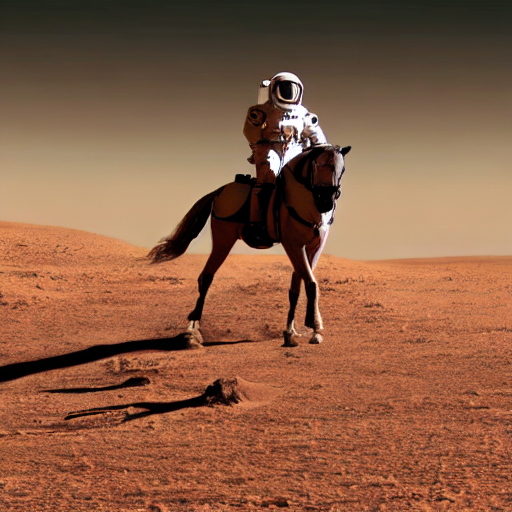

In [22]:
# the file name is the prompt with spaces replaced by underscores and all punctuation removed
file_name = f'{prompt.replace(" ", "_").replace(".", "").replace(",", "")}.png'

# Save the image and display it
image.save(file_name)
Image(filename=file_name)